# Semantic Network Analysis

Yuval Pinter, 2017-2018

## Description
Here we will analyze the graph structure of WordNet, a semantic resource mapping lemmatized English words to senses, and senses to senses related to them across multiple relation types.
This notebook is an extension of a lab prepared for Georgia Tech's course [CS-8803, Computational Social Science section](https://github.com/jacobeisenstein/gt-css-class).

First, let's get our dependencies and load the data.

In [1]:
from nltk.corpus import wordnet as wn
from collections import Counter

import numpy as np
import random as rd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# general statistics
synsets = list(wn.all_synsets())
lemmata = list(wn.all_lemma_names())
print(f'Number of synsets: {len(synsets):,}\nNumber of lemma names: {len(lemmata):,}')

Number of synsets: 117,659
Number of lemma names: 147,306


## Lemma X Sense graph
Let's create a network mapping synsets to lemmata and make sure it's bipartite.

In [3]:
wsg = nx.Graph()
wsg.add_nodes_from(synsets)
for l in set(lemmata):
    wsg.add_node(l)
    for ls in wn.synsets(l):
        wsg.add_edge(l,ls)

In [4]:
nx.is_bipartite(wsg)

True

Following up with some analysis following measures formulated in:
```
Sigman, Mariano, and Guillermo A. Cecchi. "Global organization of the Wordnet lexicon." Proceedings of the National Academy of Sciences 99.3 (2002): 1742-1747.
```

### Polysemy Graph
The polysemy graph connects a synset with another based on the fact that they share a lemma (think `financial institute` <=> `side of a river`).
This graph does not explicitly appear in WordNet, so we're creating it by **projecting** the bipartite synset/lemma graph (using the built-in function from `networkx`).

In [5]:
polys_g = nx.project(wsg, synsets)
print(f'Number of nodes: {len(polys_g.nodes()):,}')
print(f'Number of edges: {len(polys_g.edges()):,}')

Number of nodes: 117,659
Number of edges: 234,577


In [6]:
def pos_connected(e, directed=True) -> tuple:
    """
    A function telling us which parts-of-speech are participating in an edge
    :param e: an nx edge
    :param directed: True iff we care about which node comes first (not so for polysemy)
    """
    if not directed:
        return tuple(sorted([e[0].pos(), e[1].pos()]))
    return (e[0].pos(), e[1].pos())

def pos_connections(graph: nx.Graph, directed=True) -> Counter:
    """
    Counts part-of-speech relations in a graph.
    """
    return Counter([pos_connected(e, directed) for e in graph.edges()])

In [7]:
pos_polysems = pos_connections(polys_g, False)
print(f'Connection count sanity check: {sum(pos_polysems.values()):,}')
print('\n'.join([f'{p1} <-> {p2}: {ct:,} times' for (p1,p2),ct in pos_polysems.most_common()]))

Connection count sanity check: 234,577
n <-> v: 62,170 times
n <-> n: 60,674 times
v <-> v: 49,993 times
s <-> v: 18,556 times
s <-> s: 9,948 times
n <-> s: 8,581 times
a <-> s: 6,309 times
a <-> v: 5,482 times
a <-> n: 3,844 times
r <-> s: 2,421 times
r <-> r: 1,884 times
a <-> a: 1,829 times
n <-> r: 1,259 times
a <-> r: 814 times
r <-> v: 813 times


That's a lot of polysemy.
It's interesting to see that the commonest case is verb/noun polysemy, usually known as zero-derivation.

### Back to the original, unprojected graph
The graph will very likely not be connected. If language is by any means regular, it will have a lot of connected components, too, indicating that it's very far from possible to travel through a language just by lemma-synset relations.

In [8]:
len(list(nx.connected_components(wsg)))

64835

This is about a ratio of 2 synsets per component.
I'm guessing these are centered around some really high-frequency, multi-sensed lemmata. Let's verify this:

In [9]:
conncomps = list(nx.connected_components(wsg))
largest_cc = conncomps[np.argmax([len(cc) for cc in conncomps])]
print(f'The largest connected component is of size {len(largest_cc):,}')

The largest connected component is of size 68,884


In [10]:
largest_cc_lemmata = [n for n in largest_cc if type(n) == str]
largest_cc_synsets = [n for n in largest_cc if type(n) != str]
print(f'The number of lemmata in the largest cc: {len(largest_cc_lemmata):,}')
print(f'The number of synsets in the largest cc: {len(largest_cc_synsets):,}')

# part-of speech analysis
l_cc_poss = [s.pos() for s in largest_cc_synsets]
print('\nParts of speech in largest cc:')
print('\t'.join([f'{pos}: {ct:,}' for pos,ct in Counter(l_cc_poss).most_common()]))

The number of lemmata in the largest cc: 32,011
The number of synsets in the largest cc: 36,873

Parts of speech in largest cc:
n: 18,150	v: 10,437	s: 5,329	a: 2,212	r: 745


Yes. This one big connected component is a total mess, which shows us why sense mapping is necessary - projecting WordNet's sense relations onto lemmata would introduce so much noise into what we will see below are pretty clean graphs.

#### Centrality measurement

In [11]:
cent = nx.centrality.degree_centrality(wsg)
print('Most central nodes:')
print('\n'.join([f'{n}\t{c:.5f}' for n,c in sorted(cent.items(), key=lambda x: -x[1])][:10]))

Most central nodes:
break	0.00028
broken	0.00027
cut	0.00026
broke	0.00023
breaking	0.00023
run	0.00022
cutting	0.00020
play	0.00020
making	0.00020
made	0.00020


So four of the five most central nodes, all lemmata (a central synset would have been surprising), are derivations of the word `break`, and though noun synsets are the largest class, these are not quite represented in the most central nodes. This suggests that words become central less by cross-POS zero-derivation and more by POS-internal polysemy.

#### Lemma-level projection

In [12]:
lem_nodes = [n for n in wsg.nodes() if type(n) == str]
proj = nx.projected_graph(wsg, lem_nodes)

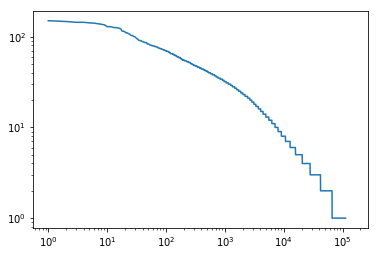

In [13]:
proj_degs = {lem:nx.degree(proj,lem) for lem in lem_nodes}
plt.loglog(sorted(proj_degs.values(),reverse=True));

This is actually not terribly far from a power law distribution, which is to be expected in a language resource (Zipf law).

## Relations
Relations are graphs within the synset network. Let's get their general densities (measured as synsets that have out degree > 0 for each relation, i.e. edges coming out of it).

In [14]:
synsets = list(wn.all_synsets())

def nonempty_rels_count(rel, dset=synsets) -> int:
    """
    Computes out degree
    """
    return len([s for s in synsets if len(rel(s)) > 0])

print(f'Total synsets: {len(synsets):,}')
rel_names = ['hypernyms', 'hyponyms', 'entailments', 'attributes', 'causes', 'member meronyms', \
             'substance meronyms', 'part meronyms', 'member holonyms', 'substance holonyms', 'part holonyms', 'similar tos']
rel_funcs = [lambda s: s.hypernyms(), lambda s: s.hyponyms(), lambda s: s.entailments(), lambda s: s.attributes(),\
                      lambda s: s.causes(), lambda s: s.member_meronyms(), lambda s: s.substance_meronyms(),\
                      lambda s: s.part_meronyms(), lambda s: s.member_holonyms(), lambda s: s.substance_holonyms(), \
                      lambda s: s.part_holonyms(), lambda s: s.similar_tos()]

for name, rel in zip(rel_names, rel_funcs):
    print(f'{nonempty_rels_count(rel):5d} have {name}') # hey, anybody know how to combine `5d` and `,` string formats?

Total synsets: 117,659
87597 have hypernyms
20008 have hyponyms
  390 have entailments
  940 have attributes
  218 have causes
 5553 have member meronyms
  666 have substance meronyms
 3699 have part meronyms
12201 have member holonyms
  551 have substance holonyms
 7859 have part holonyms
13205 have similar tos


It is clear that the "interesting" ones are going to be hypernyms/hyponyms, similar tos, meronym/holonym of the various types. Since these come in pairs, we'll just take the ones flowing top to bottom: hyponyms, meronyms.

## Hyponym DAG properties

In [15]:
def graphify(relation) -> nx.DiGraph:
    """
    Create a networkx directed graph out of a WordNet synset relation type
    """
    relg = nx.DiGraph()
    relg.add_nodes_from(synsets)
    for s in synsets:
        targets = relation(s)
        relg.add_edges_from(zip([s] * len(targets), targets))
    return relg

In [16]:
hypg = graphify(lambda s: s.hyponyms())

Let's make sure it's acyclic

In [17]:
# this'll take a while
hyponym_cycles = list(nx.cycles.simple_cycles(hypg))
print(f'There are {len(hyponym_cycles)} cycles in the hyponym graph (should be zero)')

There are 1 cycles in the hyponym graph (should be zero)


Wait, what?

In [18]:
hyponym_cycles[0]

[Synset('inhibit.v.04'), Synset('restrain.v.01')]

OK, this is a mistake. It's not seen in the hypernym graph, nor in the current [WordNet navigation tool, version 3.1](http://wordnetweb.princeton.edu/perl/webwn), which means that this was probably found and fixed by the WordNet curators.

In [19]:
hypg.remove_edge(wn.synset('inhibit.v.04'), wn.synset('restrain.v.01'))
nx.dag.is_directed_acyclic_graph(hypg)

True

Better. Now to make sure the transformation went as expected:

In [28]:
# sanity check, should be 20008

odeg_dist = Counter([x[1] for x in hypg.out_degree()])
print(f'{sum(odeg_dist.values()) - odeg_dist[0]} synsets have hyponyms')

20008 synsets have hyponyms


And that there is very little transitivity, if at all (WordNet wasn't built to include redundant information):

In [29]:
print(f'The proportion of two-paths where the first source is connected to the second target is {nx.transitivity(hypg)}')

The proportion of two-paths where the first source is connected to the second target is 1.0739941708966374e-05


Not zero, oddly enough, but we'll leave that one be. It's pretty tiny.

Let's find the root(s), i.e. un-generalizable concepts that nevertheless have hyponyms.

In [33]:
in_out_degs = {n:(i,o) for ((n,i),(n,o)) in zip(hypg.in_degree(), hypg.out_degree())}
roots = [n for n,(i,o) in in_out_degs.items() if i == 0 and o > 0]

In [34]:
print(f'Number of hyponym graph roots is {len(roots)}')
subtrees = {r:len(nx.dfs_tree(hypg, r)) for r in roots}
print('Roots with largest subgraphs:')
for x in sorted(subtrees.items(), key=lambda x:-x[1])[:10]:
    print(f'{x[0].name()} : {x[1]:,}')

Number of hyponym graph roots is 347
Roots with largest subgraphs:
entity.n.01 : 74,374
change.v.01 : 1,704
change.v.02 : 1,295
act.v.01 : 1,083
move.v.02 : 1,027
make.v.03 : 659
travel.v.01 : 526
think.v.03 : 451
transfer.v.05 : 420
move.v.03 : 329


There's many roots, and the ones with large hyponym sets (including transitive closure) are indeed broad concepts. Interestingly, almost all nouns are clustered into one huge sub-DAG under `entity` whereas the verb space is more decentralized (although not necessarily disconnected - these are not roots of trees, since multiple hypernyms do exist for some synsets).

Let's explore two similarly-sized sub-trees, the ones for `act` and `move`, and see if they are organized similarly. We'll take our inspiration from the [chain-letter paper](http://www.pnas.org/content/105/12/4633.abstract) and use their three measures.

In [35]:
act_root = wn.synset('act.v.01')
move_root = wn.synset('move.v.02')
act_st = nx.dfs_tree(hypg, act_root)
move_st = nx.dfs_tree(hypg, move_root)
print(f'Act has {len(act_st):,} hyponyms, Move has {len(move_st):,}') # verification
print(f'They have {len([s for s in act_st if s in move_st])} hyponyms in common') # intersection (not necessarily 0, since this is a DAG)

Act has 1,083 hyponyms, Move has 1,027
They have 0 hyponyms in common


Their first measure is the fraction of nodes that have a single child.

In [37]:
def sc_frac(tree):
    """
    Returns the fraction of nodes in a tree that only have one child
    """
    return len([d for _,d in tree.out_degree() if d == 1]) / len(tree)

print(f'Single-child fraction for Act is {sc_frac(act_st):.5f}')
print(f'Single-child fraction for Move is {sc_frac(move_st):.5f}')

Single-child fraction for Act is 0.11173
Single-child fraction for Move is 0.11392


The second measure is median subtree depth.

In [38]:
def all_depths(tree, root):
    return [nx.shortest_path_length(tree, root, n) for n in tree]

def med_depth(tree, root):
    return int(np.median(all_depths(tree, root)))

print(f'Median depth for Act is {med_depth(act_st, act_root)}')
print(f'Median depth for Move is {med_depth(move_st, move_root)}')

Median depth for Act is 5
Median depth for Move is 3


The third, and last, measure is the width of a tree, defined as the size of the largest depth-layer.

In [39]:
def tree_width(tree, root):
    return Counter(all_depths(tree, root)).most_common(1)[0][1]

print(f'Width for Act tree is {tree_width(act_st, act_root)}')
print(f'Width for Move tree is {tree_width(move_st, move_root)}')

Width for Act tree is 226
Width for Move tree is 311


So, while the single-child fraction is very similar, the `act` hyponym tree is deeper and narrower than the `move` hyponym tree. An immediate consequence is that hyponym structures don't emerge from a latent "distribution". In linguistic terms, what this could mean is that *movements* are more diverse in the world and happen in many contexts, whereas *actions* have less contexts but require specific denotations.

To conclude this section, a production of the full degree distributions can help us visualize the structures better and see that they are not really similarly distributed.

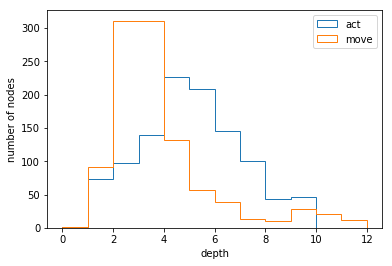

In [40]:
act_depths = all_depths(act_st, act_root)
move_depths = all_depths(move_st, move_root)
plt.hist(act_depths, bins=max(act_depths), histtype='step', label='act');
plt.hist(move_depths, bins=max(move_depths), histtype='step', label='move');
plt.xlabel('depth');
plt.ylabel('number of nodes');
plt.legend();

These don't even seem to be from the same family - `act` is somewhat Gaussian-distributed and `move` is Poissony.

## Meronym DAG

Meronym relations are part-of-whole, e.g. `tree` is a meronym of `forest`.

In [41]:
def all_meronyms(s):
    return s.part_meronyms() + s.member_meronyms() + s.substance_meronyms()

In [42]:
merg = graphify(all_meronyms)

nx.is_directed_acyclic_graph(merg)

True

Good, no structural corrections needed this time. Now for the same root exploration from the hyponym graph:

In [43]:
mer_in_out_degs = {n:(i,o) for ((n,i),(n,o)) in zip(merg.in_degree(), merg.out_degree())}
all_mer_roots = [n for n,(i,o) in mer_in_out_degs.items() if i == 0 and o > 0]

In [44]:
print(f'There are {len(all_mer_roots):,} meronym graph roots')
all_mer_trees = {r:nx.dfs_tree(merg, r) for r in all_mer_roots}
all_mer_tree_lengths = {r:len(t) for r,t in all_mer_trees.items()}

top_ten_mer_tree_sizes = sorted(all_mer_tree_lengths.items(), key=lambda x:-x[1])[:10]
print('Roots with largest subgraphs:')
for x in top_ten_mer_tree_sizes:
    print(f'{x[0].name()} : {x[1]:,}')

There are 2,748 meronym graph roots
Roots with largest subgraphs:
animalia.n.01 : 5,853
plantae.n.01 : 5,149
northern_hemisphere.n.01 : 2,259
west.n.01 : 1,942
eastern_hemisphere.n.01 : 1,566
north_atlantic_treaty_organization.n.01 : 1,562
western_hemisphere.n.01 : 1,176
america.n.02 : 1,176
organization_of_american_states.n.01 : 1,137
european_union.n.01 : 589


The largest roots correspond to semantically very large groups, which is what we'd expect!

Note that this graph is much less centralized, with much less roots. But I suspect there's going to be massive intersection in some of these.

In [45]:
nato_root = wn.synset('north_atlantic_treaty_organization.n.01')
eu_root = wn.synset('european_union.n.01')
oas_root = wn.synset('organization_of_american_states.n.01')
america_root = wn.synset('america.n.02')

def mer_intersection(r1, r2):
    return len([s for s in all_mer_trees[r1] if s in all_mer_trees[r2]])\
                / min(len(all_mer_trees[r1]), len(all_mer_trees[r2]))

print(f'Proportion of American synsets that are also in OAS: {mer_intersection(america_root, oas_root):.5f}')
print(f'Proportion of American synsets that are also in EU: {mer_intersection(america_root, eu_root):.5f}') # should be zero
print(f'Proportion of EU synsets that are also in NATO: {mer_intersection(eu_root, nato_root):.5f}')

Proportion of American synsets that are also in OAS: 0.95075
Proportion of American synsets that are also in EU: 0.00000
Proportion of EU synsets that are also in NATO: 0.94058


As suspected. Does this happen a lot?

In [48]:
intersections = 0
total_pairs = 0
only_mer_trees = list(all_mer_trees.values())
# yes, not very efficient, I know.
for i in range(len(only_mer_trees)):
    for j in range(i):
        total_pairs += 1
        if len([s for s in only_mer_trees[i] if s in only_mer_trees[j]]) > 0:
            intersections += 1
print(f'Intersctions: {intersections:,}\nTotal tree pairs: {total_pairs:,}\nIntersections per pair: {intersections/total_pairs:.5f}')

Intersctions: 2,568
Total tree pairs: 3,774,378
Intersections per pair: 0.00068


So the phenomenon in general is not very common, i.e. those 2,748 holonymic roots do a decent job of partitioning the data. Now let's see if the non-intersecting America, the EU, animalia, and plantae are a roughly scaled version of the same graph. Ideally we would use features like clustering for this, but clustering is undefined for directed graphs (at least in `networkx`). We'll use node degrees and single-children fraction again instead. Since the biological trees are much larger, we'll only compute the single-child fraction on non-leaves.

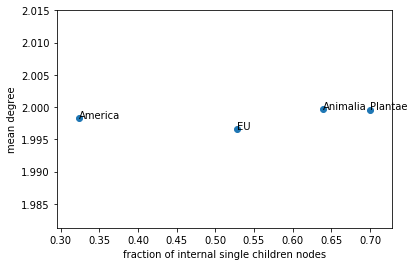

In [50]:
mer_trees = {'EU': all_mer_trees[eu_root], 'America': all_mer_trees[america_root],\
            'Animalia': all_mer_trees[wn.synset('animalia.n.01')],\
            'Plantae': all_mer_trees[wn.synset('plantae.n.01')]}

def int_sc_frac(tree):
    ods = [x[1] for x in tree.out_degree()]
    return len([d for d in ods if d == 1]) / len([d for d in ods if d > 0])

mer_degmeans = {k: np.mean([x[1] for x in t.degree()]) for k,t in mer_trees.items()} # normalizing by tree size doesn't change much
mer_scfracs = {k: int_sc_frac(t) for k,t in mer_trees.items()}

plt.scatter(mer_scfracs.values(), mer_degmeans.values());
plt.xlabel('fraction of internal single children nodes');
plt.ylabel('mean degree')
for tree_name in mer_trees:
    plt.annotate(tree_name, (mer_scfracs[tree_name], mer_degmeans[tree_name]))

These all seem far enough to uphold the findings of versatility from the hyponym analysis.

## Part-of-Speech interactions
Is every Part-of-Speech subset of synsets a hyponym island unto itself?

In [54]:
def pos_connection_viz(graph):
    print('\n'.join([f'{p1} -> {p2}: {ct:,} times' for (p1,p2),ct in pos_connections(graph).most_common()]))

print('Hyponym connections between parts of speech:')
pos_connection_viz(hypg)

Hyponym connections between parts of speech:
n -> n: 75,850 times
v -> v: 13,238 times


That's a resounding **yes**.

We saw that the common meronym roots are all nouns - is it just an all-noun graph?

What happens in some other relations?

In [55]:
print('Meronym connections between parts of speech:')
pos_connection_viz(merg)

Meronym connections between parts of speech:
n -> n: 22,187 times


Yes.

What happens in some other relations?

In [57]:
attg = graphify(lambda s: s.attributes())
print('Attribute connections between parts of speech:')
pos_connection_viz(attg)

Attribute connections between parts of speech:
a -> n: 639 times
n -> a: 639 times


Interesting - the `attributes` graph appears to be a bipartite graph between nouns and adjectives. Possibly even containing only symmetric edges - let's see:

In [58]:
nx.is_bipartite(attg)

True

In [59]:
attg_e = attg.edges()
all([(t,s) in attg_e for s,t in attg_e])

True

That's a yes. How about the `causes` graph? And the `similar tos`?

In [60]:
causg = graphify(lambda s: s.causes())
print('Causes connections between parts of speech:')
pos_connection_viz(causg)

Causes connections between parts of speech:
v -> v: 220 times


In [61]:
simtog = graphify(lambda s: s.similar_tos())
print('Similar To connections between parts of speech:')
pos_connection_viz(simtog)

Similar To connections between parts of speech:
a -> s: 10,693 times
s -> a: 10,693 times


Um, what in the what is an `s`? Let's collect a sample.

In [69]:
simtos = list(simtog.edges())
rd.shuffle(simtos)
simtos[:5]

[(Synset('known.a.01'), Synset('best-known.s.01')),
 (Synset('down.a.01'), Synset('fallen.s.01')),
 (Synset('soft.a.03'), Synset('little.s.05')),
 (Synset('symphonic.s.02'), Synset('harmonious.a.01')),
 (Synset('cucumber-shaped.s.01'), Synset('prolate.a.01'))]

OK, turns out from [WordNet's documentation](https://wordnet.princeton.edu/man/wngloss.7WN.html) that these are *satellite adjectives*, which appear only in certain contexts. In any event, it seems like the `similar to` connection was designed to keep these connected to their more literal adjective sense correlates. Are **all** satellites connected thusly to the rest of the world?

In [71]:
satellites = [s for s in synsets if s.pos() == 's']
print('Histogram for outgoing edge counts for all satellites in WordNet:')
print(Counter([len(sat.similar_tos()) for sat in satellites]).most_common())

Histogram for outgoing edge counts for all satellites in WordNet:
[(1, 10693)]


Bingo.

## Conclusion

To conclude this exploratory survey, we saw:
* That the lemma-sense mapping in WordNet is necessary to clean up a very messy English language;
* That the large hyponym and meronym graphs are each irregular from a network prespective: disjoint subtrees don't share properties, even when controlling for size;
* That some relations in WordNet function as intra-POS graphs, and others bridge between different parts-of-speech.